<h3> Import Header </h3>

In [1]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from rembg import remove

import torch
import timm
import cv2
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader 
from torchsampler import ImbalancedDatasetSampler

import wandb
# import mlflow
# import mlflow.sklearn

In [2]:
wandb.init(project='oil_base_dataset', entity='artlab')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ngp9441 (artlab). Use `wandb login --relogin` to force relogin


<h3> Set Device </h3>

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seed = 42
torch.manual_seed(seed)
if device == 'cuda':
  torch.cuda.manual_seed_all(seed)

<h3> Set Hyper Parameters </h3>

In [4]:
learning_rate = 1e-4
total_epoch = 100
batch_size = 16

<h3> Define Dataset / DataLoader </h3>

In [5]:
key = 'oil'                                                             # 학습하고자 하는 category를 설정한다. ('oil','sensitive','pigmentation','wrinkle', 'hydration' 중 택1) / oil기준 30초 소요

train_images = []                                                       # 먼저 학습 데이터에 대한 이미지와 라벨을 모으기 위해 리스트 두 개를 선언한다.
train_labels = []
valid_images = []                                                       # valid셋에 대해서도 동일한 작업을 위해 두 개의 리스트를 선언한다.
valid_labels = []

train_path = '../dataset/train' 
with open(os.path.join(train_path, "annotations.json"), "r") as json_file:
    train_ann = json.load(json_file)
images_info = train_ann['images']

for image_info in images_info:
    image_name = image_info['file_name']                                # 이미지 파일의 이름을 가져온다.
    file_name = image_name.replace('jpg', 'json')                       # 이미지에 대한 라벨링 json파일의 이름을 저장한다. (.jpg를 .json으로 변경하면 된다.)

    with open(os.path.join(train_path, file_name), "r") as json_file:   # json 파일에 접근하여 json 파일을 불러온다.
        img_json = json.load(json_file)             
    
    label = img_json[key]                                               # 학습하고자 하는 category의 라벨을 저장한다.
    
    if label < 0: continue                                              # 라벨이 -2, -1인 경우 학습에서 제외하여야 한다.

    image_path = os.path.join(train_path, image_name)                   # 이미지 경로를 불러온다.
    image = cv2.imread(image_path)                                      # 이미지를 불러오고 BGR을 RGB로 변경해준다.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    train_images.append(image)
    train_labels.append(label)

    if label == 4:
        valid_images.append(image)
        valid_labels.append(label)
    

In [6]:
valid_path = '../dataset/valid' 
with open(os.path.join(valid_path, "annotations.json"), "r") as json_file:
    valid_ann = json.load(json_file)
images_info = valid_ann['images']

for image_info in images_info:
    image_name = image_info['file_name']                                # 이미지 파일의 이름을 가져온다.
    file_name = image_name.replace('jpg', 'json')                       # 이미지에 대한 라벨링 json파일의 이름을 저장한다. (.jpg를 .json으로 변경하면 된다.)

    with open(os.path.join(valid_path, file_name), "r") as json_file:   # json 파일에 접근하여 json 파일을 불러온다.
        img_json = json.load(json_file)             
    
    label = img_json[key]                                               # 학습하고자 하는 category의 라벨을 저장한다.
    
    if label < 0: continue                                              # 라벨이 -2, -1인 경우 학습에서 제외하여야 한다.
    
    image_path = os.path.join(valid_path, image_name)                   # 이미지 경로를 불러온다.
    image = cv2.imread(image_path)                                      # 이미지를 불러오고 BGR을 RGB로 변경해준다.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    
    valid_images.append(image)
    valid_labels.append(label)

In [7]:
# train, valid dataset class를 선언한다.
class TrainDataset(Dataset):
  def __init__(self, images, labels, transform=None):
    self.images = images
    self.labels = labels
    self.transform = transform
  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, index):
    image = self.images[index]
    
    if self.transform is not None:
      image = self.transform(image=image)['image']
    
    label = self.labels[index]
    return image, label

class ValidDataset(Dataset):
  def __init__(self, images, labels, transform=None):
    self.images = images
    self.labels = labels
    self.transform = transform
  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, index):
    image = self.images[index]

    if self.transform is not None:
      image = self.transform(image=image)['image']

    label = self.labels[index]
    return image, label

In [8]:
# train과 valid에 사용할 transform을 선언한다.
train_transform = A.Compose([
    A.Resize(784, 784), 
    A.CenterCrop(512, 512),
    # A.RandomResizedCrop(p=1.0, height=512, width=512, scale=(0.7, 1.0)),
    A.ColorJitter(0.5, 0.5, 0.5, 0.25, p=0.5),
    A.OpticalDistortion(distort_limit=0.1, p=0.5),
    A.RGBShift(p=0.5 , r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), b_shift_limit=(-20, 20)),
    # A.ISONoise(p=0.7, intensity=(0.0, 0.5), color_shift=(0.0, 0.1)),
    # A.RandomBrightness(p=0.7, limit=(-0.2, 0.2)),
    
    A.HorizontalFlip(p=0.5),
    
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])
valid_transform = A.Compose([
    A.Resize(784, 784), 
    A.CenterCrop(512, 512),
    # A.RandomResizedCrop(p=1.0, height=512, width=512, scale=(0.7, 1.0)),
    # A.RandomBrightness(p=0.5),
    # A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.15, p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [9]:
# train, valid dataset을 선언한다.
train_dataset = TrainDataset(train_images, train_labels, train_transform)
valid_dataset = ValidDataset(valid_images, valid_labels, valid_transform)

In [10]:
# train. valid loader를 선언한다.
train_loader = DataLoader(train_dataset, sampler=ImbalancedDatasetSampler(train_dataset, labels=train_dataset.labels), batch_size = batch_size, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle=True, drop_last=True)

<h3> Define Model & Train </h3>

In [12]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0').to(device)

Loaded pretrained weights for efficientnet-b0


In [13]:
# for param in model.parameters():
#     param.requires_grad = False
in_features = model._fc.in_features
model._fc = nn.Linear(in_features=in_features, out_features=5, bias=True).to(device)

wandb.watch(model)

[]

In [14]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, class_num, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.class_num = class_num
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)                                   # prediction한 값을 softmax 함수에 통과시킨다.
        
        with torch.no_grad():               
            new_label = torch.zeros_like(pred)                                  # class 개수만큼 0을 채운 tensor를 만든다.
            new_label.fill_(self.smoothing / (self.class_num - 1))              # 알맞은 smoothing 값을 넣어준다.
            new_label.scatter_(1, target.data.unsqueeze(1), self.confidence)    # 기존 정답 라벨에 해당하는 인덱스에는 confidence값을 넣어준다.
            
        '''
        새로운 정답 라벨(텐서)와 softmax를 통과시킨 값을 곱한 값에 평균을 취하면 해당 이미지에 대한 loss값이 나온다.
        따라서 해당 loss값들을 모두 평균낸다.
        '''
        return torch.mean(torch.sum(-new_label * pred, dim=self.dim))           

In [15]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = LabelSmoothingLoss(5, 0.1).to(device)
# criterion = nn.CrossEntropyLoss()

In [16]:
class Metric:
    def __init__(self, num_classes=5):
        self.num_classes = num_classes
        self.matrix = [[0]*self.num_classes for _ in range(self.num_classes)]
        self.weights = [0]*(self.num_classes - 2) + [0.5, 1, 0.5] + [0]*(self.num_classes - 2)
        self.penalty = [-0.5 * i for i in range(self.num_classes - 2, 0, -1)] + [0.5, 1, 0.5] + [-0.5 * i for i in range(1, self.num_classes - 1)]
        self.epsilon = 1e-7

    def add_data(self, preds, labels):
        size = len(labels)
        preds = torch.argmax(preds, dim=-1)
        for s in range(size):
            self.matrix[int(labels[s])][int(preds[s])] += 1

    def _precision(self):
        res = []
        for i in range(self.num_classes):
            temp = []
            for j in range(self.num_classes):
                temp.append(self.matrix[j][i])
            res.append(temp[i] / (sum(temp) + self.epsilon))
        return res

    def _recall(self):
        res = []
        for i in range(self.num_classes):
            temp = self.matrix[i][i] / (sum(self.matrix[i]) + self.epsilon)
            res.append(temp)
        return res

    def _w_recall(self):
        res = []
        for i in range(self.num_classes):
            w = self.weights[self.num_classes - 1 - i: self.num_classes*2 - 1 - i]
            temp = 0
            for j in range(self.num_classes):
                temp += self.matrix[i][j] * w[j]
            temp /= (sum(self.matrix[i]) + self.epsilon)
            res.append(temp)
        return res

    def _p_recall(self):
        res = []
        for i in range(self.num_classes):
            p = self.penalty[self.num_classes - 1 - i: self.num_classes*2 - 1 - i]
            temp = 0
            for j in range(self.num_classes):
                temp += self.matrix[i][j] * p[j]
            temp /= (sum(self.matrix[i]) + self.epsilon)
            res.append(temp)
        return res

    def get_precision(self):
        pre = self._precision()
        return sum(pre)/len(pre)

    def get_recall(self):
        rec = self._recall()
        return sum(rec)/len(rec)

    def get_w_recall(self):
        wrec = self._w_recall()
        return sum(wrec)/len(wrec)

    def get_p_recall(self):
        prec = self._p_recall()
        return sum(prec)/len(prec)

In [17]:
total_train_image = len(train_dataset)                              # 총 학습 이미지의 개수를 의미한다.
total_train_batch = len(train_loader)                               # 각 에포크 당 미니 배치 개수를 의미한다.
total_val_image = len(valid_dataset)    
total_val_batch = len(valid_loader)

best_accuracy = 0
for epoch in range(total_epoch):                                    # total_epoch 값 만큼 epoch 실행한다.
  model.train()                                                     # model 학습 모드로 변경한다.
  train_accuracy = 0                                                # 해당 epoch의 accuracy와 loss를 저장할 변수 선언한다.
  train_loss = 0       
  metric = Metric()                 
  for images, labels in train_loader:   
    images = images.to(device)
    labels = labels.to(device)
    
    hypothesis = model(images)             
    loss = criterion(hypothesis, labels)                                      

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    prediction = torch.argmax(hypothesis, 1)                        # 학습 이미지에 대해 모델이 예측한 label을 저장한다.  
    correct = (prediction == labels)                                # 정답 label들과 비교한다.
    train_accuracy += correct.sum().item() / total_train_image      # accuracy 값을 갱신한다.
    train_loss += loss.item() / total_train_batch                   # loss 값을 갱신한다.

    metric.add_data(hypothesis, labels)
  train_recall = metric.get_recall()
  train_wrecall = metric.get_w_recall()
  train_precall = metric.get_p_recall()

  model.eval()
  val_accuracy = 0
  val_loss = 0
  
  with torch.no_grad():
    model.eval()
    metric = Metric()
    for images, labels in valid_loader:
      images = images.to(device)
      labels = labels.to(device)

      hypothesis = model(images)
      loss = criterion(hypothesis, labels)
      
      prediction = torch.argmax(hypothesis, 1)                        # 학습 이미지에 대해 모델이 예측한 label을 저장한다.                         
      correct = (prediction == labels)
      val_accuracy += correct.sum().item() / total_val_image
      val_loss += loss.item() / total_val_batch

      metric.add_data(hypothesis, labels)

    valid_recall = metric.get_recall()
    valid_wrecall = metric.get_w_recall()
    valid_precall = metric.get_p_recall()

    if best_accuracy < val_accuracy:
      best_accuracy = val_accuracy
      torch.save(model.state_dict(), f'model.pth')
      print(f'[epoch {epoch+1}/{total_epoch}] Model Saved. Best Accuracy: {best_accuracy:.5}')
    torch.save(model.state_dict(), f"lastest.pth")

  print(f'[epoch {epoch+1}/{total_epoch}] train_loss: {train_loss:.5} train_accuracy: {train_accuracy:.5} val_loss: {val_loss:.5} val_accuracy: {val_accuracy:.5}')
  print(f'[epoch {epoch+1}/{total_epoch}] train_recall: {train_recall:.5} train_wrecall: {train_wrecall:.5} train_precall: {train_precall:.5}')
  print(f'[epoch {epoch+1}/{total_epoch}] valid_recall: {valid_recall:.5} valid_wrecall: {valid_wrecall:.5} valid_precall: {valid_precall:.5}')
  with open('result.txt', 'a') as f:
    f.write(f'[epoch {epoch+1}/{total_epoch}] train_loss: {train_loss:.5} train_accuracy: {train_accuracy:.5} val_loss: {val_loss:.5} val_accuracy: {val_accuracy:.5}\n')
    f.write(f'[epoch {epoch+1}/{total_epoch}] train_recall: {train_recall:.5} train_wrecall: {train_wrecall:.5} train_precall: {train_precall:.5}\n')
    f.write(f'[epoch {epoch+1}/{total_epoch}] valid_recall: {valid_recall:.5} valid_wrecall: {valid_wrecall:.5} valid_precall: {valid_precall:.5}\n')
    
  wandb.log({
    "Train Loss": train_loss,
    "Train Accuracy": train_accuracy,
    "Train_recall": train_recall,
    "Train_wrecall": train_wrecall,
    "Train_precall": train_precall,
    "Valid Loss": val_loss,
    "Valid Accuracy": val_accuracy,
    "Valid_recall": valid_recall,
    "Valid_wrecall": valid_wrecall,
    "Valid_precall": valid_precall
  })

[epoch 1/100] Model Saved. Best Accuracy: 0.30986
[epoch 1/100] train_loss: 1.4149 train_accuracy: 0.42325 val_loss: 1.5589 val_accuracy: 0.30986
[epoch 1/100] train_recall: 0.42818 train_wrecall: 0.5857 train_precall: 0.39848
[epoch 1/100] valid_recall: 0.37165 valid_wrecall: 0.55569 valid_precall: 0.377
[epoch 2/100] Model Saved. Best Accuracy: 0.45272
[epoch 2/100] train_loss: 1.1578 train_accuracy: 0.59262 val_loss: 1.2839 val_accuracy: 0.45272
[epoch 2/100] train_recall: 0.60195 train_wrecall: 0.74445 train_precall: 0.6793
[epoch 2/100] valid_recall: 0.55539 valid_wrecall: 0.73926 valid_precall: 0.70083
[epoch 3/100] Model Saved. Best Accuracy: 0.48692
[epoch 3/100] train_loss: 1.0183 train_accuracy: 0.66125 val_loss: 1.2432 val_accuracy: 0.48692
[epoch 3/100] train_recall: 0.65777 train_wrecall: 0.7855 train_precall: 0.73467
[epoch 3/100] valid_recall: 0.57477 valid_wrecall: 0.7418 valid_precall: 0.69085
[epoch 4/100] Model Saved. Best Accuracy: 0.56338
[epoch 4/100] train_loss: 

<h3> Inference </h3>

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b0').to(device)

in_features = model._fc.in_features
model._fc = nn.Linear(in_features=in_features, out_features=5, bias=True).to(device)

model.load_state_dict(torch.load('./base&offaug/latest.pt'))
model.eval()

In [34]:
total_val_image = len(valid_dataset)
total_val_batch = len(valid_loader)

false_values = np.array([0 for _ in range(5)])      # 실제 라벨은 인덱스지만 다르게 예측한 경우
true_values = np.array([0 for _ in range(5)])       # 실제 라벨을 정확히 예측한 경우
prediction_values = np.array([0 for _ in range(5)]) # 예측한 값이 prediction의 개수 저장 / 즉 각 값은 각 label별 모델이 예측한 개수
part_values = {}                                    # 정답 라벨별 예측 라벨의 개수 저장
for i in range(5):
    part_values[i] = np.array([0 for _ in range(5)])

with torch.no_grad():
    val_accuracy = 0
    val_loss = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        label = labels[0].item()

        prediction = model(images)
        prediction = torch.argmax(prediction, 1)
        prediction = prediction[0].item()
        prediction_values[prediction] += 1
        if prediction == label: true_values[label] += 1
        else: false_values[label] += 1
        part_values[label][prediction] += 1

[127 258 157 149  19]
[ 81 152 258  80 181]


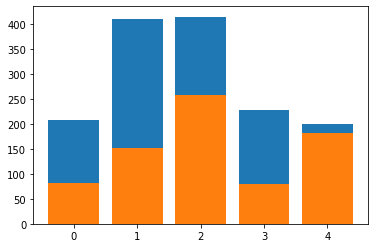

In [35]:
plt.bar([0, 1, 2, 3, 4], true_values+false_values)
plt.bar([0, 1, 2, 3, 4], true_values)
print(false_values)
print(true_values)
plt.show()

[ 62 429 798 125  48]
[ 52 164 320  41  41]


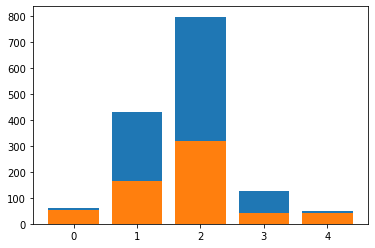

In [22]:
plt.bar([0, 1, 2, 3, 4], prediction_values)
plt.bar([0, 1, 2, 3, 4], true_values)
print(prediction_values)
print(true_values)

<AxesSubplot:>

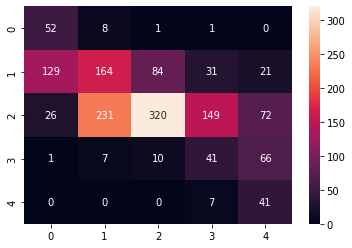

In [27]:
df = pd.DataFrame(part_values)
sns.heatmap(df, annot=True, fmt='d')